In [14]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# PATH CONSTANTS
ABSOLUTE_PATH = "/content/drive/My Drive/deepfake_tweets"
PREPROCESSED_DATA_DIR = ABSOLUTE_PATH + "/data/preprocessed"
MODEL_EXPORT_DIR = ABSOLUTE_PATH + "/models/distilbert"

Mounted at /content/drive


In [15]:
import sys
sys.path.insert(0, ABSOLUTE_PATH)

# Training DistilBERT model

In [16]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from utils import TweetDataset, train_model, evaluate_model, export_model
from tqdm import tqdm

## Loading (preprocessed) tweepfake dataset

In [17]:
# Import splits of the dataset (train, val, test)
train_set_path, val_set_path, test_set_path = (
    os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_train.csv"),
    os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_val.csv"),
    os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_test.csv")
)

train_df, val_df, test_df = (
    pd.read_csv(train_set_path),
    pd.read_csv(val_set_path),
    pd.read_csv(test_set_path)
)

# Concatenate split sets into a single DataFrame
df = pd.concat([train_df, val_df, test_df], ignore_index=True)
df.head()

,screen_name,text,account.type,class_type,text_tokens
0,imranyebot,YEA note GOOD,bot,others,yea note good
1,zawvrk,Listen Charming Man Smiths <URL>,human,human,listen charm man smith <url>
2,zawarbot,wish would seeing hoes worst part,bot,others,wish would see hoe worst part
3,ahadsheriffbot,decade significantly easier schedule like h…,bot,others,decad significantli easier schedul like h …
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn,""" theim class =\ "" alignnon size-ful wp-imag -..."


## Prepare datasets for binary classification

In [18]:
text_column = 'text_tokens' if 'text_tokens' in train_df.columns else 'text'

X_train = train_df[text_column].values
y_train = (train_df['account.type'] == 'bot').astype(int).values

X_val = val_df[text_column].values
y_val = (val_df['account.type'] == 'bot').astype(int).values

X_test = test_df[text_column].values
y_test = (test_df['account.type'] == 'bot').astype(int).values

## Load DistilBERT model

In [19]:
# MODEL CONSTANTS
MODEL_NAME = "distilbert-base-uncased"
BATCH_SIZE = 32
NUM_LABELS = 2
NUM_EPOCHS = 5

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS, output_attentions=False, output_hidden_states=False
)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Create PyTorch datasets and dataloaders

In [21]:
train_dataset = TweetDataset(X_train, y_train, tokenizer)
val_dataset = TweetDataset(X_val, y_val, tokenizer)
test_dataset = TweetDataset(X_test, y_test, tokenizer)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE)

print(f"Created dataloaders with batch size {BATCH_SIZE}")

Created dataloaders with batch size 32


## Fine-tuning DistilBERT

### Configuration

The following code defines the recommended hyperparameters for the DistilBERT model. It uses a slightly higher learning rate and more epochs compared to BERT due to the difference in sizes.

In [22]:
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% warmup
    num_training_steps=total_steps
)

### Training the model

In [23]:
finetuned_model, training_stats = train_model(
    model, train_dataloader, val_dataloader, optimizer, scheduler, epochs, device)


======== Epoch 1 / 5 ========
Training...


Training: 100%|██████████| 648/648 [03:26<00:00,  3.14it/s, loss=0.1681]


Average training loss: 0.3976
Running validation...


Validation: 100%|██████████| 72/72 [00:08<00:00,  8.75it/s]


Validation Loss: 0.3574
Validation Accuracy: 0.8262
Validation F1 Score: 0.8283
New best model with validation accuracy: 0.8262

======== Epoch 2 / 5 ========
Training...


Training: 100%|██████████| 648/648 [03:33<00:00,  3.03it/s, loss=0.0844]


Average training loss: 0.2705
Running validation...


Validation: 100%|██████████| 72/72 [00:08<00:00,  8.77it/s]


Validation Loss: 0.3136
Validation Accuracy: 0.8558
Validation F1 Score: 0.8600
New best model with validation accuracy: 0.8558

======== Epoch 3 / 5 ========
Training...


Training: 100%|██████████| 648/648 [03:34<00:00,  3.03it/s, loss=0.0054]


Average training loss: 0.1612
Running validation...


Validation: 100%|██████████| 72/72 [00:08<00:00,  8.91it/s]


Validation Loss: 0.3985
Validation Accuracy: 0.8449
Validation F1 Score: 0.8436

======== Epoch 4 / 5 ========
Training...


Training: 100%|██████████| 648/648 [03:33<00:00,  3.03it/s, loss=0.0200]


Average training loss: 0.0734
Running validation...


Validation: 100%|██████████| 72/72 [00:08<00:00,  8.79it/s]


Validation Loss: 0.7063
Validation Accuracy: 0.8449
Validation F1 Score: 0.8471

======== Epoch 5 / 5 ========
Training...


Training: 100%|██████████| 648/648 [03:33<00:00,  3.03it/s, loss=0.0003]


Average training loss: 0.0344
Running validation...


Validation: 100%|██████████| 72/72 [00:08<00:00,  8.77it/s]

Validation Loss: 0.8797
Validation Accuracy: 0.8410
Validation F1 Score: 0.8406
Loaded best model with validation accuracy: 0.8558


## Evaluation on the test set

In [24]:
eval_results = evaluate_model(finetuned_model, test_dataloader, device)

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  8.91it/s]


In [25]:
loss, accuracy, f1 = eval_results['loss'], eval_results['accuracy'], eval_results['f1']
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Test Loss: 0.8600
Test Accuracy: 0.8358
Test F1 Score: 0.8370


In [26]:
print("\nClassification Report:")
print(classification_report(eval_results['true_labels'], eval_results['predictions'],
                          target_names=['Human', 'Bot']))


Classification Report:
              precision    recall  f1-score   support

       Human       0.84      0.83      0.83      1278
         Bot       0.83      0.84      0.84      1280

    accuracy                           0.84      2558
   macro avg       0.84      0.84      0.84      2558
weighted avg       0.84      0.84      0.84      2558



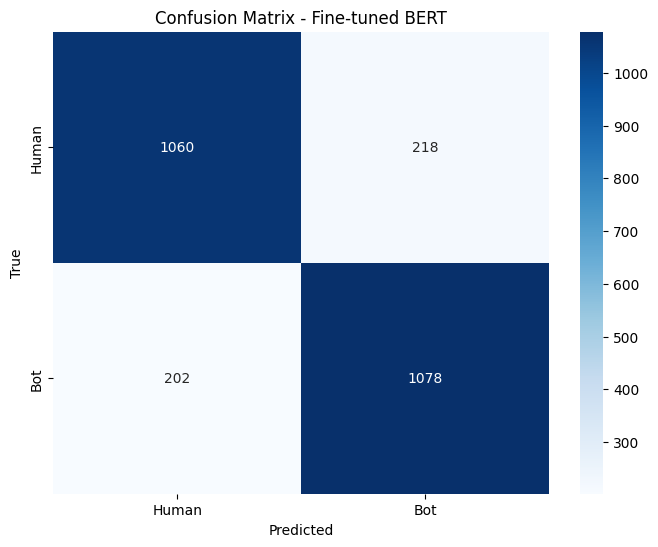

In [27]:
cm = confusion_matrix(eval_results['true_labels'], eval_results['predictions'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Fine-tuned BERT')
plt.show()

## Export fine-tuned DistilBERT model

In [28]:
export_model(finetuned_model, tokenizer, MODEL_EXPORT_DIR)